# Figures for the AGU presentation

In [1]:
import discretize
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle, Ellipse
from matplotlib.collections import PatchCollection

In [2]:
plt.style.use('seaborn-talk')

In [3]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
#        [ -500,  500, -4000, 4000,  -1600, -850]
block1 = [ -450,  450, -3950, 3950,  -1550, -900]
#        [    0, 5000, -3000,    0,  -1850, -1600]
block2 = [   50, 4950, -2950,  -50,  -1800, -1650]
#        [-5000,    0,     0, 3000, -2900, -1600]
block3 = [-4950,  -50,    50, 2950, -2850, -1650]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

In [4]:
x0 = -10000
hx = np.diff(np.unique(np.r_[x0, block1[:2], block2[:2], block3[:2], -x0]))

y0 = -10000
hy = np.diff(np.unique(np.r_[y0, block1[2:4], block2[2:4], block3[2:4], -y0]))

z0 = -3400
hz = np.diff(np.unique(np.r_[z0, block1[4:], block2[4:], block3[4:], depth, 500]))

# Initiate the mesh
mesh = discretize.TensorMesh([hx, hy, hz], x0=np.array([x0, y0, z0]))

In [5]:
# 1.A Initiate the horizontal and vertical resistivity models
resh = np.zeros(mesh.nC)
resv = np.zeros(mesh.nC)

# 1.B Define layered background model
resh[mesh.gridCC[:, 2] > depth[0]] = res1d[0]     # Air
resv[mesh.gridCC[:, 2] > depth[0]] = res1d[0]*aniso[0]**2
resh[mesh.gridCC[:, 2] <= depth[0]] = res1d[1]    # Water
resv[mesh.gridCC[:, 2] <= depth[0]] = res1d[1]*aniso[1]**2
resh[mesh.gridCC[:, 2] <= depth[1]] = res1d[2]    # Overburden
resv[mesh.gridCC[:, 2] <= depth[1]] = res1d[2]*aniso[2]**2
resh[mesh.gridCC[:, 2] <= depth[2]] = res1d[3]    # Background
resv[mesh.gridCC[:, 2] <= depth[2]] = res1d[3]*aniso[3]**2
resh[mesh.gridCC[:, 2] <= depth[-1]] = res1d[-1]  # Basement
resv[mesh.gridCC[:, 2] <= depth[-1]] = res1d[-1]*aniso[-1]**2

# Store as background resistivity
resh_bg = resh.copy()
resv_bg = resv.copy()

# 1.C Add the three blocks
for i, block in enumerate([block1, block2, block3]):
    block_i = (
        (mesh.gridCC[:, 0] >= block[0]) & (mesh.gridCC[:, 0] <= block[1]) &
        (mesh.gridCC[:, 1] >= block[2]) & (mesh.gridCC[:, 1] <= block[3]) &
        (mesh.gridCC[:, 2] >= block[4]) & (mesh.gridCC[:, 2] <= block[5])
    )
    resh[block_i] = resistivities[i]
    resv[block_i] = resistivities[i]
    
# Reshape them
resh = resh.reshape(mesh.vnC, order='F')
resv = resv.reshape(mesh.vnC, order='F')
resh_bg = resh_bg.reshape(mesh.vnC, order='F')
resv_bg = resv_bg.reshape(mesh.vnC, order='F')

In [6]:
# Source: x-directed electric dipole of 200 m length, 50 meter above seafloor
src = np.array([-100., 100, 0, 0, -550, -550])
src_c = np.mean(src.reshape(-1, 2), 1)
strength = 800.0  # 800 A strength => 160 kAm source
freq = 1.0        # 1 Hz frequency

# 3 Receiver lines
rec_x = np.linspace(-10., 10, 101)*1e3
rec_y = np.array([-3., 0, 3])*1e3
rec_z = -600.0

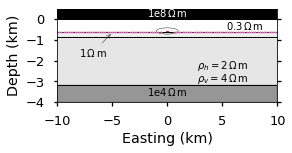

In [7]:
ls = ['C0', 'C1', 'C2']
alpha = [0.1, 0.2, 0.3]
# Background-alpha is a function of log10-resistivity
alphabg = (np.log10(res1d)-min(np.log10(res1d)))/max(np.log10(res1d)-min(np.log10(res1d)))
xlim = [-10, 10]
ylim = [-5.5, 5.5]
zlim = [-4, 0.5]

fig = plt.figure(figsize=(6, 5.5))
fig.subplots_adjust(wspace=.075, hspace=.1)

# X-Z
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2, rowspan=1)
ax2.yaxis.set_ticks_position('both')

# Draw layered background
prev = zlim[1]
for i, d in enumerate(np.r_[depth, zlim[0]*1e3]):
    plt.fill_between([xlim[0], xlim[1]], [prev, prev],
                     [d/1e3, d/1e3],
                     color='k', alpha=alphabg[i])
    if i < 4:
        plt.axhline(d/1e3, c='k', lw=1)
    prev = d/1e3
    
# Annotate background resistivities
plt.text(0, 0.1, r'1e8$\,\Omega\,$m', c='w', horizontalalignment='center')
plt.text(7, -0.5, r'0.3$\,\Omega\,$m', horizontalalignment='center')
plt.annotate(r'1$\,\Omega\,$m', (-5, -0.65), xytext=(-8, -1.8), arrowprops=dict(arrowstyle="->"))
plt.text(5, -2.4, r'$\rho_h=2\,\Omega\,$m', horizontalalignment='center')
plt.text(5, -3, r'$\rho_v=4\,\Omega\,$m', horizontalalignment='center')
plt.text(0, -3.7, r'1e4$\,\Omega\,$m', horizontalalignment='center')

# Source and receivers
plt.plot(np.array([src[0], src[1]])/1000, np.array([src[4], src[5]])/1000, 'C3', lw=1)
rec_xx = rec_x.copy()
rec_xx[abs(rec_x)<500] = np.nan  # min_offset
plt.plot(rec_xx/1000, rec_x*0+rec_z/1000, 'C6.', ms=4)

ax2.set_xlabel('Easting (km)')
ax2.set_xlim([xlim[0], xlim[1]])
ax2.set_ylabel('Depth (km)')
ax2.set_ylim([zlim[0], zlim[1]])
ax2.set_yticks([0, -1, -2, -3, -4])

p = PatchCollection([Ellipse((0, -0.57), 2, 0.3), ], ec='k', fc='none', alpha=1)
ax2.add_collection(p)

plt.savefig('../figures/model-layered.pdf', bbox_inches='tight')
plt.show()

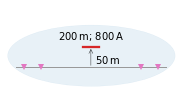

In [8]:
fig, ax = plt.subplots(figsize=(3, 1.5))

    
ix=46
# Move source by 50 m up for better visibility
plt.plot([-0.9, 0.9], [-0.6, -0.6], '.6', lw=1)
plt.text(0, -0.530, r'200$\,$m; 800$\,$A', horizontalalignment='center')
plt.plot([src[0]/1e3, src[1]/1e3], [src[4]/1e3, src[5]/1e3], 'C3')
plt.plot(rec_xx[ix:-ix]/1e3, rec_x[ix:-ix]*0+rec_z/1e3, 'C6v', ms=6)
plt.annotate(r'', (0, -0.55), xytext=(0, -0.6), arrowprops=dict(arrowstyle="->"))
plt.text(0.05, -0.59, r'50$\,$m')


p = PatchCollection([Ellipse((0, -0.57), 2, 0.15), ], ec='C0', fc='C0', alpha=0.1)
ax.add_collection(p)


#plt.axhline(d/1e3, c='k', lw=1)
plt.xlim([-1, 1])
plt.ylim([-0.65, -0.45])
plt.yticks([-0.55, -0.6])
plt.axis('off')

plt.savefig('../figures/model-layered-src.pdf', bbox_inches='tight')
plt.show()

/home/dtr/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/dtr/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/dtr/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

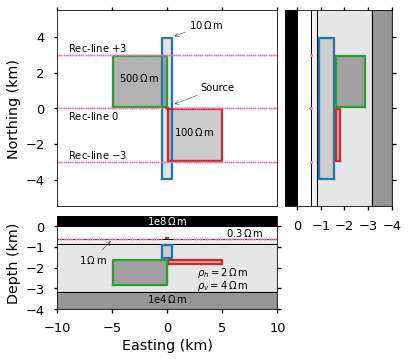

In [9]:
ls = ['C0', 'C3', 'C2']
alpha = [0.1, 0.2, 0.3]
# Background-alpha is a function of log10-resistivity
alphabg = (np.log10(res1d)-min(np.log10(res1d)))/max(np.log10(res1d)-min(np.log10(res1d)))
xlim = [-10, 10]
ylim = [-5.5, 5.5]
zlim = [-4, 0.5]

fig = plt.figure(figsize=(6, 5.5))
fig.subplots_adjust(wspace=.075, hspace=.1)

# X-Y
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2) #, aspect='equal')

# Draw blocks
for i, b in enumerate([block1, block2, block3]):
    tg = plt.Rectangle((b[0]/1e3, b[2]/1e3),
                       np.diff(b[:2])/1e3, np.diff(b[2:4])/1e3,
                       facecolor="black", alpha=alpha[i])
    ax1.add_patch(tg)
    plt.plot(np.r_[b[:2], b[1::-1], b[0]]/1e3,
             np.r_[2*[b[2]], 2*[b[3]], b[2]]/1e3, ls[i])

# Annotate block resistivities
plt.annotate(r'$10\,\Omega\,$m', (0.5, 4), xytext=(2, 4.5), arrowprops=dict(arrowstyle="->"))
plt.text(2.5, -1.5, r'$100\,\Omega\,$m', horizontalalignment='center')
plt.text(-2.5, 1.5, r'$500\,\Omega\,$m', horizontalalignment='center')
plt.text(-9, -0.6, 'Rec-line $0$')
plt.text(-9, 3.2, r'Rec-line $+3$')
plt.text(-9, -2.8, r'Rec-line $-3$')
plt.annotate('Source', (0.5, 0.2), xytext=(3, 1), arrowprops=dict(arrowstyle="->"))
    
# Plot source and receiver lines
plt.plot(rec_x/1e3, -3+0*rec_x, 'C6.', ms=4)
plt.plot(rec_xx/1e3, 0*rec_xx, 'C6.', ms=4)
plt.plot(rec_x/1e3, 3+0*rec_x, 'C6.', ms=4)
plt.plot(np.array([src[0], src[1]])/1000, np.array([src[2], src[3]])/1000, 'C3')

ax1.set_ylabel('Northing (km)')
ax1.set_xlim([xlim[0], xlim[1]])
ax1.set_ylim([ylim[0], ylim[1]])
ax1.xaxis.set_ticks_position('top')
plt.setp(ax1.get_xticklabels(), visible=False)

# X-Z
ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=2, rowspan=1, sharex=ax1)
ax2.yaxis.set_ticks_position('both')

# Draw layered background
prev = zlim[1]
for i, d in enumerate(np.r_[depth, zlim[0]*1e3]):
    plt.fill_between([xlim[0], xlim[1]], [prev, prev],
                     [d/1e3, d/1e3],
                     color='k', alpha=alphabg[i])
    if i < 4:
        plt.axhline(d/1e3, c='k', lw=1)
    prev = d/1e3
    
# Draw blocks
for i, b in enumerate([block1, block2, block3]):
    tg = plt.Rectangle((b[0]/1e3, b[4]/1e3),
                       np.diff(b[:2])/1e3, np.diff(b[4:])/1e3,
                       facecolor="black", alpha=alpha[i])
    ax2.add_patch(tg)
    plt.plot(np.r_[b[:2], b[1::-1], b[0]]/1e3,
             np.r_[2*[b[4]], 2*[b[5]], b[4]]/1e3, ls[i])

# Annotate background resistivities
plt.text(0, 0.1, r'1e8$\,\Omega\,$m', c='w', horizontalalignment='center')
plt.text(7, -0.5, r'0.3$\,\Omega\,$m', horizontalalignment='center')
plt.annotate(r'1$\,\Omega\,$m', (-5, -0.65), xytext=(-8, -1.8), arrowprops=dict(arrowstyle="->"))
plt.text(5, -2.4, r'$\rho_h=2\,\Omega\,$m', horizontalalignment='center')
plt.text(5, -3, r'$\rho_v=4\,\Omega\,$m', horizontalalignment='center')
plt.text(0, -3.7, r'1e4$\,\Omega\,$m', horizontalalignment='center')

plt.plot(rec_xx/1e3, -0.6+0*rec_xx, 'C6.', ms=4)
plt.plot(np.array([src[0], src[1]])/1000, np.array([src[4], src[5]])/1000, 'C3')


ax2.set_xlabel('Easting (km)')
ax2.set_xlim([xlim[0], xlim[1]])
ax2.set_ylabel('Depth (km)')
ax2.set_ylim([zlim[0], zlim[1]])
ax2.set_yticks([0, -1, -2, -3, -4])

# Z-Y
ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1, rowspan=2, sharey=ax1)

# Draw layered background
prev = zlim[1]
for i, d in enumerate(np.r_[depth, zlim[0]*1e3]):
    plt.fill_betweenx([ylim[0], ylim[1]], [prev, prev],
                     [d/1e3, d/1e3],
                     color='k', alpha=alphabg[i])
    if i < 4:
        plt.axvline(d/1e3, c='k', lw=1)
    prev = d/1e3
    
# Draw blocks
for i, b in enumerate([block1, block2, block3]):
    tg = plt.Rectangle((b[4]/1e3, b[2]/1e3),
                       np.diff(b[4:])/1e3, np.diff(b[2:4])/1e3,
                       facecolor="black", alpha=alpha[i])
    ax3.add_patch(tg)
    plt.plot(np.r_[b[4:], b[-1:3:-1], b[4]]/1e3,
             np.r_[2*[b[2]], 2*[b[3]], b[2]]/1e3, ls[i])

plt.plot(np.array([src[4], src[5]])/1000, np.array([src[2], src[3]])/1000, 'C3o', ms=2)
plt.plot(np.ones(3)*rec_z/1e3, np.array([-3, 0, 3]), 'C6.', ms=6)

ax3.yaxis.set_ticks_position('right')
ax3.xaxis.set_ticks_position('both')
ax3.invert_xaxis()
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_ylim([ylim[0], ylim[1]])
ax3.set_xlim([zlim[1], zlim[0]])
ax3.set_xticks([0, -1, -2, -3, -4])

plt.savefig('../figures/model-block.pdf', bbox_inches='tight')
plt.show()